# 1. Pengaturan Awal, Instalasi, dan Impor Pustaka

> **Tujuan:** Mempersiapkan lingkungan kerja.

Sel ini bertanggung jawab untuk melakukan tiga hal penting:

1.  **Menginstal Library:** Memastikan semua pustaka Python yang diperlukan (`pandas`, `scikit-learn`, `nltk`, `tensorflow`) telah terinstal di lingkungan Colab. Perintah `!pip install -q` melakukannya secara "quiet" (tanpa output yang ramai).
2.  **Mengimpor Modul:** Mengimpor semua modul dan pustaka yang akan digunakan di seluruh notebook ke dalam memori.
3.  **Verifikasi Lingkungan:** Memeriksa dan menampilkan versi TensorFlow yang digunakan serta memverifikasi apakah GPU terdeteksi, yang merupakan langkah krusial untuk memastikan training berjalan cepat.

In [1]:
# ==============================================================================
# Sel 1: Pengaturan Awal, Instalasi, dan Impor Pustaka
# ==============================================================================
# Menginstal library yang diperlukan dan mengimpor semua modul yang akan digunakan.

print("Installing required libraries...")
!pip install pandas -q
!pip install scikit-learn -q
!pip install nltk -q
!pip install tensorflow -q

import os
import re
import pickle
import collections
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
print("\nTensorFlow Version:", tf.__version__)
print("Setup complete.")

Installing required libraries...
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

TensorFlow Version: 2.18.0
Setup complete.


# 2. Koneksi ke Google Drive

> **Tujuan:** Mengakses dataset yang disimpan di Google Drive.

Sel ini menjalankan proses otentikasi untuk menghubungkan (mounting) akun Google Drive Anda ke sistem file sementara Colab. Setelah berhasil, direktori Drive Anda akan dapat diakses di path `/content/drive/MyDrive/`, memungkinkan notebook ini untuk membaca file `train.csv` dan `test.csv` secara langsung.

In [7]:
# ==============================================================================
# Sel 2: Hubungkan Google Drive
# ==============================================================================
# Karena saya menaruh dataset di Google Drive, maka saya harus menghubungkannya agar dataset bisa terbaca
# Sel ini akan menghubungkan Google Drive Anda ke lingkungan Colab.
# Anda akan diminta untuk melakukan otentikasi.

from google.colab import drive

print("Mounting Google Drive...")

# Use a try-except block to catch potential errors and suggest retrying or restarting
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    print("Please try rerunning this cell. If the error persists, restart the Colab runtime and try again.")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.


# 3. Pipeline Data yang Dioptimalkan untuk Skalabilitas

> **Peringatan:** Sel ini berisi versi **refactor** dan **teroptimalkan** dari semua fungsi utilitas data. Tujuannya adalah untuk menangani dataset berskala penuh secara efisien, terutama dalam lingkungan dengan memori terbatas seperti Google Colab.

---

### Mengapa Ada Perubahan?

Versi sebelumnya memuat seluruh dataset ke dalam memori sekaligus. Pendekatan ini sangat boros RAM dan berisiko menyebabkan sesi *crash* saat bekerja dengan 560.000+ baris data.

Versi baru ini dirancang untuk menjadi lebih:
- **Cepat** dalam pemrosesan.
- **Hemat Memori** secara signifikan.
- **Robust** dan tahan terhadap kegagalan.

---

### Optimisasi Utama yang Diterapkan

1.  **Pemrosesan per Potongan (`Chunking`)**
    * *Fungsi seperti `build_word_dict_optimized` sekarang membaca file CSV besar dalam potongan-potongan kecil. Ini secara drastis mengurangi penggunaan memori puncak (peak RAM usage).*

2.  **Penggunaan Tipe Data yang Efisien**
    * *Saat memuat data dengan `pandas`, tipe data dioptimalkan (misalnya, `category` untuk kolom kelas, `int8` untuk angka kecil) untuk menghemat puluhan hingga ratusan megabyte RAM.*

3.  **Pembagian Data yang *Stratified***
    * *`train_test_split` sekarang menggunakan parameter `stratify=y`. Ini adalah praktik terbaik yang memastikan proporsi setiap kelas di data training dan validation sama persis.*

4.  **Struktur Kode Modular & Terpusat**
    * *Semua logika—mulai dari memuat, membersihkan, hingga membuat pipeline `tf.data`—dibungkus dalam satu fungsi utama: `setup_data_pipeline_optimized`.*

5.  **Manajemen Memori Eksplisit**
    * *Penggunaan `gc.collect()` di beberapa tempat membantu "memaksa" Python untuk melepaskan memori yang tidak lagi digunakan, menjaga sesi Colab tetap ramping.*

---

### Cara Penggunaan

Di sel notebook berikutnya, Anda hanya perlu memanggil **satu fungsi utama** untuk menjalankan semua proses persiapan data.

```python
# Panggil fungsi ini untuk menjalankan semua proses persiapan data
data_payload = setup_data_pipeline_optimized()
```
Fungsi ini akan mengembalikan sebuah `dictionary` yang berisi semua pipeline data (`train_ds`, `valid_ds`, dll.) dan informasi penting lainnya yang siap digunakan untuk melatih semua model Anda.

In [4]:
# ==============================================================================
# Sel 3: Logika Utilitas Data (dari data_utils.py)
# ==============================================================================
# Fungsi-fungsi ini sekarang akan membaca data langsung dari Google Drive Anda.

# PENTING: Sesuaikan path ini jika folder 'dbpedia_csv' Anda tidak berada
# di direktori root 'My Drive'.
# Contoh: '/content/drive/MyDrive/folder_proyek/dbpedia_csv/'

from functools import lru_cache
import gc

# Configuration
DRIVE_PATH = '/content/drive/MyDrive/dbpedia_csv/'
TRAIN_PATH = os.path.join(DRIVE_PATH, "train.csv")
TEST_PATH = os.path.join(DRIVE_PATH, "test.csv")
WORD_DICT_PATH = "word_dict.pickle"

# Optimized text cleaning with compiled regex
CLEAN_REGEX = re.compile(r"[^A-Za-z0-9(),!?\'\`\"]")
WHITESPACE_REGEX = re.compile(r"\s{2,}")

@lru_cache(maxsize=10000)
def clean_str_cached(text):
    """Cached version of clean_str for repeated text processing."""
    if not isinstance(text, str):
        return ""
    text = CLEAN_REGEX.sub(" ", text)
    text = WHITESPACE_REGEX.sub(" ", text)
    return text.strip().lower()

def clean_str_batch(texts):
    """Vectorized text cleaning for better performance."""
    # Convert to numpy array for vectorized operations
    texts = np.array(texts, dtype=object)

    # Apply cleaning function
    cleaned = []
    for text in texts:
        if isinstance(text, str):
            text = CLEAN_REGEX.sub(" ", text)
            text = WHITESPACE_REGEX.sub(" ", text)
            cleaned.append(text.strip().lower())
        else:
            cleaned.append("")

    return cleaned

def verify_drive_dataset():
    """Verify dataset exists with better error handling."""
    if not os.path.exists(DRIVE_PATH):
        raise FileNotFoundError(
            f"Folder 'dbpedia_csv' not found at {DRIVE_PATH}. "
            "Please check the path and ensure the folder exists in your Google Drive."
        )

    # Check if files exist
    for path in [TRAIN_PATH, TEST_PATH]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Required file not found: {path}")

    print(f"Dataset verified at: {DRIVE_PATH}")

def build_word_dict_optimized():
    """
    Optimized word dictionary building with memory management.
    """
    if os.path.exists(WORD_DICT_PATH):
        print("Loading existing word dictionary...")
        with open(WORD_DICT_PATH, "rb") as f:
            word_dict = pickle.load(f)
        return word_dict

    print("Building word dictionary (optimized version)...")

    # Use chunked reading to manage memory
    chunk_size = 10000
    word_counter = collections.Counter()

    for chunk in pd.read_csv(TRAIN_PATH, names=["class", "title", "content"],
                            dtype=str, skiprows=1, chunksize=chunk_size):
        # Process content in batches
        cleaned_content = clean_str_batch(chunk["content"].fillna("").values)

        for content in cleaned_content:
            if content:
                tokens = word_tokenize(content)
                word_counter.update(tokens)

        # Force garbage collection after each chunk
        del chunk, cleaned_content
        gc.collect()

    # Build dictionary from counter
    word_dict = {"<pad>": 0, "<unk>": 1, "<eos>": 2}
    for word, _ in word_counter.most_common():
        word_dict[word] = len(word_dict)

    # Save dictionary
    with open(WORD_DICT_PATH, "wb") as f:
        pickle.dump(word_dict, f)

    print(f"Word dictionary created with {len(word_dict)} words")
    return word_dict

def load_and_clean_dataframe_optimized(path, sample_size=None):
    """
    Optimized data loading with better memory management.
    """
    print(f"Loading data from: {os.path.basename(path)}")

    # Use appropriate dtypes to save memory
    dtypes = {
        'class': 'category',  # Use category for class labels
        'title': 'string',
        'content': 'string'
    }

    df = pd.read_csv(path, names=["class", "title", "content"],
                    dtype=dtypes, skiprows=1)

    # Efficient class cleaning
    df["class"] = pd.to_numeric(df["class"], errors='coerce')
    df = df.dropna(subset=["class"])
    df["class"] = df["class"].astype('int8')  # Use int8 for small integers
    df = df[df["class"] > 0].reset_index(drop=True)

    # Apply sampling if needed
    if sample_size and sample_size < len(df):
        df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
        print(f"Sampled to {sample_size} records")

    print(f"Loaded {len(df)} records")
    return df

def build_dataset_optimized(df, word_dict, document_max_len, mode='word'):
    """
    Optimized dataset building with better memory management.
    """
    if mode == 'word':
        return build_word_dataset_optimized(df, word_dict, document_max_len)
    elif mode == 'char':
        return build_char_dataset_optimized(df, document_max_len)
    else:
        raise ValueError("Mode must be 'word' or 'char'")

def build_word_dataset_optimized(df, word_dict, document_max_len):
    """
    Memory-efficient word dataset building.
    """
    print("Building word dataset...")

    # Process in chunks to manage memory
    chunk_size = 5000
    all_x = []

    for i in range(0, len(df), chunk_size):
        chunk_df = df.iloc[i:i+chunk_size]

        # Clean and tokenize
        cleaned_content = clean_str_batch(chunk_df["content"].fillna("").values)

        # Tokenize and convert to indices
        chunk_x = []
        for content in cleaned_content:
            if content:
                tokens = word_tokenize(content)
                indices = [word_dict.get(w, word_dict["<unk>"]) for w in tokens]
                indices.append(word_dict["<eos>"])
                chunk_x.append(indices)
            else:
                chunk_x.append([word_dict["<eos>"]])

        all_x.extend(chunk_x)

        # Clean up
        del chunk_df, cleaned_content, chunk_x
        gc.collect()

    # Pad sequences efficiently
    x_padded = tf.keras.preprocessing.sequence.pad_sequences(
        all_x, maxlen=document_max_len, padding='post',
        truncating='post', value=word_dict["<pad>"], dtype='int32'
    )

    # Prepare labels
    y = (df["class"].values - 1).astype('int32')

    print(f"Word dataset built: {x_padded.shape}")
    return x_padded, y

def build_char_dataset_optimized(df, document_max_len):
    """
    Memory-efficient character dataset building.
    """
    print("Building character dataset...")

    # Character dictionary
    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{} "
    char_dict = {"<pad>": 0, "<unk>": 1}
    for c in alphabet:
        char_dict[c] = len(char_dict)

    alphabet_size = len(char_dict)

    # Process in chunks
    chunk_size = 5000
    all_x = []

    for i in range(0, len(df), chunk_size):
        chunk_df = df.iloc[i:i+chunk_size]

        # Convert to character indices
        chunk_x = []
        for content in chunk_df["content"].fillna("").values:
            if isinstance(content, str):
                indices = [char_dict.get(c, char_dict["<unk>"]) for c in content.lower()]
                chunk_x.append(indices)
            else:
                chunk_x.append([])

        all_x.extend(chunk_x)

        # Clean up
        del chunk_df, chunk_x
        gc.collect()

    # Pad sequences
    x_padded = tf.keras.preprocessing.sequence.pad_sequences(
        all_x, maxlen=document_max_len, padding='post',
        truncating='post', value=char_dict["<pad>"], dtype='int32'
    )

    # Prepare labels
    y = (df["class"].values - 1).astype('int32')

    print(f"Character dataset built: {x_padded.shape}")
    return x_padded, y, alphabet_size

def create_optimized_pipeline(x, y, batch_size, is_training=True):
    """
    Create optimized tf.data pipeline with better performance.
    """
    dataset = tf.data.Dataset.from_tensor_slices((x, y))

    if is_training:
        # Shuffle with appropriate buffer size
        buffer_size = min(len(x), 10000)  # Cap buffer size for memory efficiency
        dataset = dataset.shuffle(buffer_size, seed=42, reshuffle_each_iteration=True)

    # Batch and prefetch
    dataset = dataset.batch(batch_size, drop_remainder=is_training)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # Cache if dataset is small enough
    if len(x) * x.itemsize < 1e9:  # Less than 1GB
        dataset = dataset.cache()

    return dataset

def setup_data_pipeline_optimized(sample_size=None, batch_size=64,
                                word_max_len=100, char_max_len=1014):
    """
    Complete optimized data pipeline setup.
    """

    # Verify dataset
    verify_drive_dataset()

    # Load dataframes
    print("\n1. Loading dataframes...")
    train_df = load_and_clean_dataframe_optimized(TRAIN_PATH, sample_size)
    test_df = load_and_clean_dataframe_optimized(TEST_PATH, sample_size)

    # Build word dictionary
    print("\n2. Building word dictionary...")
    word_dict = build_word_dict_optimized()
    vocabulary_size = len(word_dict)

    # Build word datasets
    print("\n3. Building word datasets...")
    train_x_word, train_y_word = build_word_dataset_optimized(train_df, word_dict, word_max_len)
    test_x_word, test_y_word = build_word_dataset_optimized(test_df, word_dict, word_max_len)

    # Split training data
    train_x_word, valid_x_word, train_y_word, valid_y_word = train_test_split(
        train_x_word, train_y_word, test_size=0.15, random_state=42, stratify=train_y_word
    )

    # Create word pipelines
    print("\n4. Creating word data pipelines...")
    train_ds = create_optimized_pipeline(train_x_word, train_y_word, batch_size, is_training=True)
    valid_ds = create_optimized_pipeline(valid_x_word, valid_y_word, batch_size, is_training=False)
    test_ds = create_optimized_pipeline(test_x_word, test_y_word, batch_size, is_training=False)

    # Build character datasets
    print("\n5. Building character datasets...")
    train_x_char, train_y_char, alphabet_size = build_char_dataset_optimized(train_df, char_max_len)
    test_x_char, test_y_char, _ = build_char_dataset_optimized(test_df, char_max_len)

    # Split character training data
    train_x_char, valid_x_char, train_y_char, valid_y_char = train_test_split(
        train_x_char, train_y_char, test_size=0.15, random_state=42, stratify=train_y_char
    )

    # Create character pipelines
    print("\n6. Creating character data pipelines...")
    train_ds_char = create_optimized_pipeline(train_x_char, train_y_char, batch_size, is_training=True)
    valid_ds_char = create_optimized_pipeline(valid_x_char, valid_y_char, batch_size, is_training=False)
    test_ds_char = create_optimized_pipeline(test_x_char, test_y_char, batch_size, is_training=False)

    # Clean up large arrays from memory
    del train_x_word, train_x_char, test_x_word, test_x_char
    del valid_x_word, valid_x_char
    gc.collect()

    # Summary
    print("\n" + "="*60)
    print("PIPELINE SETUP COMPLETE")
    print("="*60)
    print(f"Vocabulary Size: {vocabulary_size:,}")
    print(f"Alphabet Size: {alphabet_size}")
    print(f"Word samples - Train: {len(train_y_word):,} | Valid: {len(valid_y_word):,} | Test: {len(test_y_word):,}")
    print(f"Char samples - Train: {len(train_y_char):,} | Valid: {len(valid_y_char):,} | Test: {len(test_y_char):,}")

    return {
        'word_data': {
            'train_ds': train_ds,
            'valid_ds': valid_ds,
            'test_ds': test_ds,
            'vocabulary_size': vocabulary_size
        },
        'char_data': {
            'train_ds': train_ds_char,
            'valid_ds': valid_ds_char,
            'test_ds': test_ds_char,
            'alphabet_size': alphabet_size
        },
        'word_dict': word_dict
    }

print("\nData utility functions defined.")
print("--> Functions have been refactored for improved efficiency and readability.")


Data utility functions defined.
--> Functions have been refactored for improved efficiency and readability.


# 4. Definisi Arsitektur Model

> **Tujuan:** Mendefinisikan semua arsitektur model yang akan dieksperimenkan.

Sel ini adalah *blueprint* untuk semua model machine learning yang akan kita latih. Setiap model diimplementasikan sebagai fungsi Python terpisah yang membuat dan mengompilasi model Keras. Pendekatan ini membuat kode menjadi modular dan mudah dikelola.

### Model yang Didefinisikan:

-   **`create_dense_model`**: Baseline sederhana (Bag-of-Words).
-   **`create_word_cnn_model`**: Implementasi TextCNN, efektif untuk menangkap pola frasa kunci.
-   **`create_vdcnn_model`**: Model usulan (VDCNN) yang sangat dalam dengan *residual connections*.
-   **`create_char_cnn_model`**: Model CNN level karakter sebagai pembanding.
-   **`create_word_rnn_model`**: Model RNN (Bi-LSTM) untuk menangkap konteks sekuensial.
-   **`create_attention_rnn_model`**: Model Bi-LSTM yang ditingkatkan dengan mekanisme *attention*.
-   **`create_rcnn_model`**: Model hibrida yang menggabungkan RNN dan CNN.
-   **`get_model`**: Sebuah fungsi "pabrik" (factory) yang memudahkan pembuatan model hanya dengan memanggil namanya.


In [2]:
# ==============================================================================
# Sel 4: Definisi Model (TensorFlow 2.x Keras API)
# ==============================================================================
# Di sini, setiap class model lama dari TF1.x diterjemahkan menjadi sebuah fungsi
# yang membuat dan mengembalikan model Keras yang sudah dikompilasi.

# --- Model Pembanding: Jaringan Neural Padat (Dense/Bag-of-Words) ---
def create_dense_model(vocabulary_size, num_class):
    """Metode pembanding sederhana. Model ini cukup sederhana, jadi learning rate default 'adam' tidak masalah."""
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=128, name="embedding"),
        tf.keras.layers.GlobalAveragePooling1D(name="pooling"),
        tf.keras.layers.Dense(128, activation='relu', name="hidden_dense"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_class, name="output") # Logits output
    ], name="Simple_Dense_Model")

    model.compile(
        optimizer='adam', # Default lr=1e-3, cocok untuk model sederhana ini
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

# --- Model-Model CNN ---

# --- Model Pembanding: WordCNN (TextCNN oleh Yoon Kim) ---
def create_word_cnn_model(vocabulary_size, document_max_len, num_class):
    """Metode WordCNN."""
    inputs = tf.keras.Input(shape=(document_max_len,), dtype='int32')
    x = tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=128)(inputs)

    conv_blocks = []
    filter_sizes = [3, 4, 5]
    for size in filter_sizes:
        conv = tf.keras.layers.Conv1D(filters=100, kernel_size=size, activation='relu')(x)
        pool = tf.keras.layers.GlobalMaxPooling1D()(conv)
        conv_blocks.append(pool)

    x = tf.keras.layers.Concatenate()(conv_blocks)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_class)(x)

    model = tf.keras.Model(inputs, outputs, name="WordCNN_Model")
    model.compile(
        # PERUBAHAN: Menggunakan learning rate yang lebih rendah untuk stabilitas
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

# --- Model Usulan: VDCNN (TextCNN oleh Yoon Kim) ---
def create_vdcnn_model(alphabet_size, document_max_len, num_class, depth=9):
    """
    VDCNN implementation with correctly handled residual connections,
    closely following the paper's architecture diagram (Figure 2).
    """

    # Block configurations for different depths from the paper
    N_BLOCKS = {
        9: (1, 1, 1, 1),
        17: (2, 2, 2, 2),
        29: (5, 5, 2, 2),
        49: (8, 8, 5, 3)
    }

    def k_max_pooling(x, k=8):
        """K-max pooling operation helper function."""
        x_transposed = tf.transpose(x, [0, 2, 1])
        top_k = tf.nn.top_k(x_transposed, k=k, sorted=False)[0]
        return tf.transpose(top_k, [0, 2, 1])

    def conv_block(x, filters):
        """
        A single convolutional block containing two Conv1D layers.
        This block does NOT include the residual connection or pooling.
        """
        # First convolutional layer in the block
        x = tf.keras.layers.Conv1D(
            filters=filters,
            kernel_size=3,
            padding='same',
            kernel_initializer='he_normal'
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)

        # Second convolutional layer in the block
        x = tf.keras.layers.Conv1D(
            filters=filters,
            kernel_size=3,
            padding='same',
            kernel_initializer='he_normal'
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)
        return x

    # --- Start of Model Definition ---

    if depth not in N_BLOCKS:
        raise ValueError(f"Depth {depth} not supported. Choose from {list(N_BLOCKS.keys())}")

    block_counts = N_BLOCKS[depth]
    filter_sizes = [64, 128, 256, 512]

    # Input layer
    inputs = tf.keras.Input(shape=(document_max_len,), dtype='int32')

    # Embedding layer
    x = tf.keras.layers.Embedding(input_dim=alphabet_size, output_dim=16)(inputs)

    # Initial convolution (Temporal Convolution)
    x = tf.keras.layers.Conv1D(
        filters=64,
        kernel_size=3,
        padding='same',
        kernel_initializer='he_normal'
    )(x)

    # --- Main Convolutional Body ---
    for i in range(len(block_counts)):
        num_filters = filter_sizes[i]
        num_blocks = block_counts[i]

        for j in range(num_blocks):
            # Store the input for the residual connection
            residual = x

            # Apply the convolutional block
            x = conv_block(x, filters=num_filters)

            # --- Residual Connection Logic ---
            # If the number of filters has changed, we need to use a 1x1 convolution
            # on the residual to match the dimensions before adding.
            if residual.shape[-1] != num_filters:
                residual = tf.keras.layers.Conv1D(
                    filters=num_filters,
                    kernel_size=1, # 1x1 convolution for projection
                    kernel_initializer='he_normal'
                )(residual)
                residual = tf.keras.layers.BatchNormalization()(residual)

            x = tf.keras.layers.Add()([x, residual])
            x = tf.keras.layers.ReLU()(x)

        # Apply MaxPooling AFTER each group of blocks, except the last one
        if i < len(block_counts) - 1:
            x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    # K-max pooling (k=8)
    x = tf.keras.layers.Lambda(lambda y: k_max_pooling(y, k=8))(x)

    # Flatten for the dense layers
    x = tf.keras.layers.Flatten()(x)

    # Fully connected layers
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(2048, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(2048, activation='relu', kernel_initializer='he_normal')(x)

    # Output layer
    outputs = tf.keras.layers.Dense(num_class)(x)

    # Create and compile the model
    model = tf.keras.Model(inputs, outputs, name=f"VDCNN_Depth_{depth}")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

# --- Model Pembanding: CharCNN ---
def create_char_cnn_model(alphabet_size, document_max_len, num_class):
    """Metode CharCNN (Character-level)."""
    filter_sizes = [7, 7, 3, 3, 3, 3]
    num_filters = 256

    inputs = tf.keras.Input(shape=(document_max_len,), dtype='int32')

    # CATATAN: tf.one_hot bisa sangat memakan memori (RAM) untuk dataset besar.
    # Penggunaan Embedding layer adalah alternatif yang lebih efisien secara memori.
    # PERUBAHAN: Menambahkan output_shape to Lambda layer for shape inference
    x = tf.keras.layers.Lambda(
        lambda i: tf.one_hot(i, depth=alphabet_size),
        output_shape=(document_max_len, alphabet_size)
    )(inputs)

    # Convolutional Layers
    for i in range(2):
        x = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=filter_sizes[i], activation='relu')(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=3)(x)
    for i in range(2, 5):
        x = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=filter_sizes[i], activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=filter_sizes[5], activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)

    # Fully Connected Layers
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_class)(x)

    model = tf.keras.Model(inputs, outputs, name="CharCNN_Model")
    model.compile(
        # PERUBAHAN: Menggunakan learning rate yang lebih rendah untuk stabilitas
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

# --- Model-Model RNN ---

# --- Model Pembanding: WordRNN (Stacked Bi-LSTM) ---
def create_word_rnn_model(vocabulary_size, document_max_len, num_class):
    """
    WordRNN following Graves (2013) and Schuster & Paliwal (1997) Bidirectional LSTM.
    More faithful implementation with proper layer sizes and configuration.
    """
    inputs = tf.keras.Input(shape=(document_max_len,), dtype='int32')

    # Embedding layer - using standard 300-dim for word-level tasks
    x = tf.keras.layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=300,
        mask_zero=True  # Handle variable length sequences properly
    )(inputs)

    # First Bidirectional LSTM layer
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            dropout=0.2
        )
    )(x)

    # Second Bidirectional LSTM layer (without return_sequences for final classification)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            dropout=0.2
        )
    )(x)

    # Final classification layer
    outputs = tf.keras.layers.Dense(num_class)(x)

    model = tf.keras.Model(inputs, outputs, name="WordRNN_Model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Slightly higher LR for RNNs
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

# --- Model Pembanding: AttentionRNN ---
def create_attention_rnn_model(vocabulary_size, document_max_len, num_class):
    """
    Attention-Based Bidirectional Long Short-Term Memory Networks for Relation Classification
    (Zhou et al., 2016). Faithful implementation of the original architecture.
    """
    inputs = tf.keras.Input(shape=(document_max_len,), dtype='int32')

    # Word embeddings (as used in the original paper)
    embedded = tf.keras.layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=300,  # 300-dim word embeddings as in paper
        mask_zero=True
    )(inputs)

    # Bidirectional LSTM layer
    # The paper uses hidden size of 100 for each direction (total 200)
    lstm_output = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            100,
            return_sequences=True,
            dropout=0.5  # Dropout as mentioned in paper
        ),
        name='bidirectional_lstm'
    )(embedded)

    # Attention mechanism as described in Zhou et al. (2016)
    # Step 1: Compute attention scores using a feed-forward network
    attention_hidden = tf.keras.layers.Dense(
        200,  # Hidden size for attention mechanism
        activation='tanh',
        name='attention_hidden'
    )(lstm_output)

    # Step 2: Compute attention weights
    attention_weights = tf.keras.layers.Dense(
        1,
        activation=None,  # No activation here
        name='attention_weights'
    )(attention_hidden)

    # Step 3: Apply softmax to get normalized attention weights
    attention_weights = tf.keras.layers.Softmax(axis=1, name='attention_softmax')(attention_weights)

    # Step 4: Compute weighted representation (sentence-level representation)
    # This is the key part: weighted sum of LSTM outputs
    sentence_representation = tf.keras.layers.Dot(
        axes=1,
        name='weighted_representation'
    )([lstm_output, attention_weights])

    # Remove the extra dimension
    sentence_representation = tf.keras.layers.Lambda(
        lambda x: tf.squeeze(x, axis=2),
        name='squeeze_representation'
    )(sentence_representation)

    # Optional: Add dropout before final classification
    sentence_representation = tf.keras.layers.Dropout(0.5)(sentence_representation)

    # Final classification layer
    outputs = tf.keras.layers.Dense(
        num_class,
        name='classification'
    )(sentence_representation)

    model = tf.keras.Model(inputs, outputs, name="AttentionBiLSTM_Model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

# --- Model Pembanding: RCNN (Recurrent Convolutional Neural Network) ---
def create_rcnn_model(vocabulary_size, document_max_len, num_class):
    """
    Recurrent Convolutional Neural Networks (Lai et al., 2015).
    Improved implementation with proper context window and pooling strategy.
    """
    inputs = tf.keras.Input(shape=(document_max_len,), dtype='int32')

    # Word embeddings, e(w_i)
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=50,  # Hyperparameter
        mask_zero=True
    )(inputs)

    # Left context vector, c_l(w_i), using a forward LSTM
    lstm_left = tf.keras.layers.LSTM(50, return_sequences=True, go_backwards=False)(embedding_layer)

    # Right context vector, c_r(w_i), using a backward LSTM
    lstm_right = tf.keras.layers.LSTM(50, return_sequences=True, go_backwards=True)(embedding_layer)

    # ** CRUCIAL STEP **: Reverse the backward LSTM's output to align sequences
    lstm_right = tf.keras.layers.Lambda(lambda x: tf.reverse(x, axis=[1]))(lstm_right)

    # Create the word representation from the paper: x_i = [c_l(w_i), e(w_i), c_r(w_i)]
    concatenated = tf.keras.layers.Concatenate(axis=2)([lstm_left, embedding_layer, lstm_right])

    # Apply the non-linear transformation: y_i = tanh(W * x_i + b)
    # A Dense layer applied to a sequence is a time-distributed transformation.
    transformed = tf.keras.layers.Dense(100, activation='tanh')(concatenated)

    # Apply max-pooling over the time dimension to get the final feature vector
    pooled = tf.keras.layers.GlobalMaxPooling1D()(transformed)

    # Output layer for classification
    outputs = tf.keras.layers.Dense(num_class)(pooled)

    model = tf.keras.Model(inputs, outputs, name="RCNN_Model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        # A robust and numerically stable loss function for integer-based labels
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model


# Fungsi untuk membuat model berdasarkan nama
def get_model(model_name, vocab_size, max_len, num_class, alphabet_size=None):
    """Updated model factory function with improved implementations."""
    if model_name == 'dense':
        return create_dense_model(vocab_size, num_class)
    elif model_name == 'word_cnn':
        return create_word_cnn_model(vocab_size, max_len, num_class)
    elif model_name == 'vd_cnn':
        if alphabet_size is None:
            raise ValueError("alphabet_size is required for VDCNN model")
        return create_vdcnn_model(
            alphabet_size=alphabet_size,
            document_max_len=max_len,
            num_class=num_class,
            depth=29  # Bisa mengubah depth di sini: 9, 17, 29, atau 49
        )
    elif model_name == 'char_cnn':
        if alphabet_size is None:
            raise ValueError("alphabet_size must be provided for char_cnn model.")
        return create_char_cnn_model(alphabet_size, max_len, num_class)
    elif model_name == 'word_rnn':
        return create_word_rnn_model(vocab_size, max_len, num_class)
    elif model_name == 'attention_rnn':
        return create_attention_rnn_model(vocab_size, max_len, num_class)
    elif model_name == 'rcnn':
        return create_rcnn_model(vocab_size, max_len, num_class)
    else:
        raise ValueError(f"Unknown model: {model_name}")

print("Modern Keras model creation functions defined and updated with best practices.\n")
print("""✅ Toolkit Model Siap!
Model yang telah dibuat:
- Model Berbasis Kata (Word-based): `dense`, `word_cnn`, `word_rnn`, `attention_rnn`, `rcnn`
- Model Berbasis Karakter (Char-based): `char_cnn`, `vd_cnn`""")

Modern Keras model creation functions defined and updated with best practices.

✅ Toolkit Model Siap! 
Model yang telah dibuat:
- Model Berbasis Kata (Word-based): `dense`, `word_cnn`, `word_rnn`, `attention_rnn`, `rcnn`
- Model Berbasis Karakter (Char-based): `char_cnn`, `vd_cnn`


# 5. Pengaturan Pipeline Data

> **Tujuan:** Menjalankan seluruh proses persiapan data secara terpusat dan efisien.

Sel ini adalah "ruang mesin" dari notebook ini. Ia menggunakan fungsi-fungsi utilitas yang telah dioptimalkan dari `Sel 3` untuk melakukan semua langkah persiapan data:

1.  **Memuat & Membersihkan Data:** Membaca file `train.csv` dan `test.csv`.
2.  **Membangun Kamus:** Membuat kamus untuk kata dan karakter.
3.  **Transformasi Data:** Mengubah teks menjadi urutan angka (sequences).
4.  **Membuat Pipeline `tf.data`:** Mengonversi data menjadi objek `tf.data.Dataset` yang sangat efisien untuk disalurkan ke GPU, lengkap dengan *shuffling*, *batching*, dan *prefetching*.

Setelah sel ini selesai dijalankan, semua data (baik kata maupun karakter) siap digunakan untuk melatih semua model tanpa perlu melakukan pemrosesan ulang.

In [8]:
# ==============================================================================
# Sel 5: Pengaturan Global, Pemuatan Data, dan Pembuatan Pipeline (OPTIMIZED)
# ==============================================================================
# Versi yang dioptimalkan menggunakan fungsi-fungsi baru dari Sel 3

import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("NLTK 'punkt' resource checked/downloaded.")

# --- PENGATURAN UTAMA ---
SAMPLE_SIZE = None  # Atur ke None untuk menggunakan seluruh dataset
NUM_CLASS = 14
BATCH_SIZE = 64
NUM_EPOCHS = 50
WORD_MAX_LEN = 100
CHAR_MAX_LEN = 1014  # Disimpan untuk model berbasis karakter

# --- SETUP PIPELINE DATA YANG DIOPTIMALKAN ---
print("\n" + "="*60)
print("MEMULAI SETUP PIPELINE DATA YANG DIOPTIMALKAN")
print("="*60)

# Gunakan fungsi setup yang sudah dioptimalkan
data_pipelines = setup_data_pipeline_optimized(
    sample_size=SAMPLE_SIZE,
    batch_size=BATCH_SIZE,
    word_max_len=WORD_MAX_LEN,
    char_max_len=CHAR_MAX_LEN
)

# Ekstrak dataset untuk kemudahan akses
print("\nExtracting datasets for easy access...")

# Word-based datasets
train_ds = data_pipelines['word_data']['train_ds']
valid_ds = data_pipelines['word_data']['valid_ds']
test_ds = data_pipelines['word_data']['test_ds']
vocabulary_size = data_pipelines['word_data']['vocabulary_size']

# Character-based datasets
train_ds_char = data_pipelines['char_data']['train_ds']
valid_ds_char = data_pipelines['char_data']['valid_ds']
test_ds_char = data_pipelines['char_data']['test_ds']
alphabet_size = data_pipelines['char_data']['alphabet_size']

# Word dictionary for future use
word_dict = data_pipelines['word_dict']

print("\n" + "="*60)
print("SETUP PIPELINE DATA SELESAI")
print("="*60)
print("Semua dataset siap untuk training")
print("Memory usage telah dioptimalkan")
print("Pipeline tf.data telah dikonfigurasi dengan optimal")

# Verify pipeline shapes (optional)
print("\nVerifying pipeline shapes...")
for batch_x, batch_y in train_ds.take(1):
    print(f"Word batch shape: X={batch_x.shape}, Y={batch_y.shape}")
    break

for batch_x, batch_y in train_ds_char.take(1):
    print(f"Char batch shape: X={batch_x.shape}, Y={batch_y.shape}")
    break

print("\nAll pipelines ready for model training!")

NLTK 'punkt' resource checked/downloaded.

MEMULAI SETUP PIPELINE DATA YANG DIOPTIMALKAN
Dataset verified at: /content/drive/MyDrive/dbpedia_csv/

1. Loading dataframes...
Loading data from: train.csv
Loaded 520000 records
Loading data from: test.csv
Loaded 65000 records

2. Building word dictionary...
Building word dictionary (optimized version)...
Word dictionary created with 563010 words

3. Building word datasets...
Building word dataset...
Word dataset built: (520000, 100)
Building word dataset...
Word dataset built: (65000, 100)

4. Creating word data pipelines...

5. Building character datasets...
Building character dataset...
Character dataset built: (520000, 1014)
Building character dataset...
Character dataset built: (65000, 1014)

6. Creating character data pipelines...

PIPELINE SETUP COMPLETE
Vocabulary Size: 563,010
Alphabet Size: 71
Word samples - Train: 442,000 | Valid: 78,000 | Test: 65,000
Char samples - Train: 442,000 | Valid: 78,000 | Test: 65,000

Extracting datase

# 6. Inisialisasi Tempat Hasil Pelatihan

> **Tujuan:** Menyiapkan tempat untuk menyimpan hasil performa dari setiap model.

Sel ini hanya menjalankan satu perintah sederhana: membuat sebuah `dictionary` kosong bernama `results`.

Variabel ini akan berfungsi sebagai "papan skor" global. Setiap kali sebuah model selesai dilatih dan dievaluasi, hasilnya (akurasi dan loss) akan disimpan ke dalam kamus ini. Ini memungkinkan kita untuk dengan mudah membandingkan semua model di sel analisis akhir.

In [9]:
# ==============================================================================
# Sel 6: Inisialisasi Hasil Pelatihan
# ==============================================================================
# Jalankan sel ini sekali untuk membuat kamus tempat menyimpan hasil.
# Jika Anda menjalankan ulang pelatihan model, Anda tidak perlu menjalankan sel ini lagi
# kecuali Anda ingin mereset semua hasil.

results = {}
print("Results dictionary initialized.")

Results dictionary initialized.


# **Kategori 1: Model Pembanding (Baseline)**

Model dalam kategori ini sengaja dibuat sederhana untuk menjadi titik acuan. Model ini, yang dikenal sebagai Feedforward Neural Network dengan pendekatan Bag-of-Words, mengabaikan urutan kata dan hanya fokus pada kata-kata apa saja yang ada dalam dokumen. Tujuannya adalah untuk melihat seberapa baik performa yang bisa dicapai dengan informasi paling dasar sebelum menggunakan arsitektur yang lebih kompleks.

In [13]:
# ==============================================================================
# Sel 7: Pelatihan Model - Dense (Pembanding)
# ==============================================================================
# Jalankan sel ini untuk melatih dan mengevaluasi model Dense.

model_name = 'dense'
print("\n" + "="*50)
print(f"Training and evaluating: {model_name}")
print("="*50)

# PERUBAHAN: Mendefinisikan callback yang benar
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Memantau val_loss
    patience=5,         # Kesabaran 5 epoch
    mode='min',         # Mode 'min' untuk meminimalkan loss
    verbose=1,
    restore_best_weights=True
)

model_dense = get_model(model_name, vocabulary_size, WORD_MAX_LEN, NUM_CLASS)
model_dense.summary()

# PERUBAHAN: Melatih dengan pipeline tf.data
history_dense = model_dense.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=valid_ds,
    callbacks=[early_stopping_callback]
)

# PERUBAHAN: Mengevaluasi dengan pipeline tf.data
loss, accuracy = model_dense.evaluate(test_ds, verbose=0)
results[model_name] = {'loss': loss, 'accuracy': accuracy}

print(f"\nEvaluation for {model_name}:")
print(f"  Test Loss: {loss:.4f}")
print(f"  Test Accuracy: {accuracy:.4f}")


Training and evaluating: dense


Model: "Simple_Dense_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling                         │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_dense (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.8340 - loss: 0.5606 - val_accuracy: 0.9850 - val_loss: 0.0551
Epoch 2/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9860 - loss: 0.0524 - val_accuracy: 0.9861 - val_loss: 0.0510
Epoch 3/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9909 - loss: 0.0332 - val_accuracy: 0.9816 - val_loss: 0.0700
Epoch 4/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9933 - loss: 0.0245 - val_accuracy: 0.9837 - val_loss: 0.0730
Epoch 5/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9951 - loss: 0.0182 - val_accuracy: 0.9851 - val_loss: 0.0719
Epoch 6/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9959 - loss: 0.0146 - val_accuracy: 0.9856 - val_loss: 0.0761
Epoch 7/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9964 - loss: 0.0124 - val_accuracy: 0.9843 - val_loss: 0.0904
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


# **Kategori 2: Model Berbasis CNN (Convolutional Neural Network)**

Model dalam kategori ini menggunakan operasi konvolusi untuk memindai teks dan mengekstrak fitur-fitur penting seperti frasa atau n-gram. CNN sangat efektif dalam mengenali pola lokal yang informatif, di mana pun pola tersebut muncul dalam teks.

In [14]:
# ==============================================================================
# Sel 8: Pelatihan Model - WordCNN
# ==============================================================================
# Jalankan sel ini untuk melatih dan mengevaluasi model CharCNN.

model_name = 'word_cnn'
print("\n" + "="*50)
print(f"Training and evaluating: {model_name}")
print("="*50)

# PERUBAHAN: Mendefinisikan callback yang benar
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

model_word_cnn = get_model(model_name, vocabulary_size, WORD_MAX_LEN, NUM_CLASS)
model_word_cnn.summary()

# PERUBAHAN: Melatih dengan pipeline tf.data
history_word_cnn = model_word_cnn.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=valid_ds,
    callbacks=[early_stopping_callback]
)

# PERUBAHAN: Mengevaluasi dengan pipeline tf.data
loss, accuracy = model_word_cnn.evaluate(test_ds, verbose=0)
results[model_name] = {'loss': loss, 'accuracy': accuracy}

print(f"\nEvaluation for {model_name}:")
print(f"  Test Loss: {loss:.4f}")
print(f"  Test Accuracy: {accuracy:.4f}")


Training and evaluating: word_cnn


Model: "WordCNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 128)  │ 72,065,280 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 98, 100)   │     38,500 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 97, 100)   │     51,300 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 96, 100)   │     64,100 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 300)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 300)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 14)        │      4,214 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 72,223,394 (275.51 MB)

 Trainable params: 72,223,394 (275.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7290 - loss: 0.9664 - val_accuracy: 0.9809 - val_loss: 0.0704
Epoch 2/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9790 - loss: 0.0766 - val_accuracy: 0.9875 - val_loss: 0.0454
Epoch 3/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9869 - loss: 0.0484 - val_accuracy: 0.9896 - val_loss: 0.0379
Epoch 4/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9905 - loss: 0.0360 - val_accuracy: 0.9906 - val_loss: 0.0342
Epoch 5/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9925 - loss: 0.0284 - val_accuracy: 0.9911 - val_loss: 0.0322
Epoch 6/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9942 - loss: 0.0230 - val_accuracy: 0.9916 - val_loss: 0.0310
Epoch 7/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9954 - loss: 0.0182 - val_accuracy: 0.9918 - val_loss: 0.0305
Epoch 8/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9963 - loss: 0

In [41]:
# ==============================================================================
# Sel 9: Pelatihan Model - VDCNN (metode sesuai referensi)
# ==============================================================================
# Jalankan sel ini untuk melatih dan mengevaluasi model VDCNN.
# PERUBAHAN: Tidak ada lagi pemuatan data di sini. Sel ini HANYA untuk training.
model_name = 'vd_cnn'
print("\n" + "="*50)
print(f"Training and evaluating: {model_name}")
print("="*50)

# Callback untuk mengurangi learning rate saat performa stagnan
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', # Memantau validation loss
    factor=0.1,         # Kurangi LR sebesar 10x (misal: 0.01 -> 0.001)
    patience=2,         # Kurangi LR jika val_loss tidak membaik selama 2 epoch
    verbose=1,
    min_lr=1e-6         # Learning rate minimum
)

# Definisikan juga early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

model_vd_cnn = get_model(model_name, None, CHAR_MAX_LEN, NUM_CLASS, alphabet_size=alphabet_size)
model_vd_cnn.summary()

# PERUBAHAN: Melatih dengan pipeline tf.data untuk karakter
history_vd_cnn = model_vd_cnn.fit(
    train_ds_char,
    epochs=NUM_EPOCHS,
    validation_data=valid_ds_char,
    callbacks=[early_stopping_callback, reduce_lr_callback] # Gunakan kedua callback
)

# PERUBAHAN: Mengevaluasi dengan pipeline tf.data untuk karakter
loss, accuracy = model_vd_cnn.evaluate(test_ds_char, verbose=0)
results[model_name] = {'loss': loss, 'accuracy': accuracy}

print(f"\nEvaluation for {model_name}:")
print(f"  Test Loss: {loss:.4f}")
print(f"  Test Accuracy: {accuracy:.4f}")


Training and evaluating: vd_cnn


Model: "VDCNN_Depth_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 1014)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, 1014, 16)  │      1,136 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 1014, 64)  │      3,136 │ embedding_17[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 1014, 64)  │     12,352 │ conv1d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1014, 64)  │        256 │ conv1d_43[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 1014, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 1014, 64)  │     12,352 │ re_lu_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1014, 64)  │        256 │ conv1d_44[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 1014, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 1014, 64)  │          0 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 1014, 64)  │     12,352 │ re_lu_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1014, 64)  │        256 │ conv1d_45[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 1014, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 1014, 64)  │     12,352 │ re_lu_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1014, 64)  │        256 │ conv1d_46[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 1014, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_31 (ReLU)     │ (None, 1014, 64)  │          0 │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 1014, 64)  │     12,352 │ re_lu_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1014, 64)  │        256 │ conv1d_47[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_32 (ReLU)     │ (None, 1014, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,851,902 (64.28 MB)

 Trainable params: 16,840,126 (64.24 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 198s 24ms/step - accuracy: 0.4088 - loss: 2.1088 - val_accuracy: 0.9286 - val_loss: 0.2347 - learning_rate: 1.0000e-04
Epoch 2/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - accuracy: 0.9453 - loss: 0.1875 - val_accuracy: 0.9649 - val_loss: 0.1212 - learning_rate: 1.0000e-04
Epoch 3/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - accuracy: 0.9706 - loss: 0.1049 - val_accuracy: 0.9686 - val_loss: 0.1069 - learning_rate: 1.0000e-04
Epoch 4/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - accuracy: 0.9784 - loss: 0.0771 - val_accuracy: 0.9634 - val_loss: 0.1365 - learning_rate: 1.0000e-04
Epoch 5/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - accuracy: 0.9827 - loss: 0.0633 - val_accuracy: 0.9797 - val_loss: 0.0720 - learning_rate: 1.0000e-04
Epoch 6/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - accuracy: 0.9848 - loss: 0.0542 - val_accuracy: 0.9825 - val_loss: 0.0632 - learning_rate: 1.0000e-04
Epoch 7/50
6906/6906 ━━━━━━━━━━━━━

In [16]:
# ==============================================================================
# Sel 10: Pelatihan Model - CharCNN
# ==============================================================================
# Jalankan sel ini untuk melatih dan mengevaluasi model CharCNN.
# PERUBAHAN: Sel ini telah diperbarui untuk menggunakan pipeline tf.data dan praktik terbaik.

model_name = 'char_cnn'
print("\n" + "="*50)
print(f"Training and evaluating: {model_name}")
print("="*50)

# PERUBAHAN: Mendefinisikan callback EarlyStopping yang benar
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

# PERUBAHAN: Tidak ada lagi pemuatan data di sini, semua sudah disiapkan di Sel 5
model_char_cnn = get_model(model_name, None, CHAR_MAX_LEN, NUM_CLASS, alphabet_size=alphabet_size)
model_char_cnn.summary()

# PERUBAHAN: Melatih dengan pipeline tf.data untuk karakter
history_char_cnn = model_char_cnn.fit(
    train_ds_char,
    epochs=NUM_EPOCHS,
    validation_data=valid_ds_char,
    callbacks=[early_stopping_callback]
)

# PERUBAHAN: Mengevaluasi dengan pipeline tf.data untuk karakter
loss, accuracy = model_char_cnn.evaluate(test_ds_char, verbose=0)
results[model_name] = {'loss': loss, 'accuracy': accuracy}

print(f"\nEvaluation for {model_name}:")
print(f"  Test Loss: {loss:.4f}")
print(f"  Test Accuracy: {accuracy:.4f}")


Training and evaluating: char_cnn


Model: "CharCNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1014)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1014, 71)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 1008, 256)      │       127,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 336, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 330, 256)       │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 110, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 108, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 106, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 104, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 102, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 26112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │    26,739,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 14)             │        14,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,177,614 (111.30 MB)

 Trainable params: 29,177,614 (111.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 65s 9ms/step - accuracy: 0.5675 - loss: 1.2184 - val_accuracy: 0.9568 - val_loss: 0.1420
Epoch 2/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.9613 - loss: 0.1276 - val_accuracy: 0.9769 - val_loss: 0.0805
Epoch 3/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.9791 - loss: 0.0722 - val_accuracy: 0.9817 - val_loss: 0.0662
Epoch 4/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.9857 - loss: 0.0504 - val_accuracy: 0.9815 - val_loss: 0.0693
Epoch 5/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.9894 - loss: 0.0373 - val_accuracy: 0.9794 - val_loss: 0.0757
Epoch 6/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.9917 - loss: 0.0290 - val_accuracy: 0.9829 - val_loss: 0.0677
Epoch 7/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.9932 - loss: 0.0232 - val_accuracy: 0.9819 - val_loss: 0.0785
Epoch 8/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.9946 - loss: 0

# **Kategori 3: Model Berbasis RNN (Recurrent Neural Network)**

Model dalam kategori ini dirancang untuk memproses data sekuensial. Mereka membaca teks kata demi kata dan menggunakan "memori" (hidden state) untuk memahami konteks dan dependensi antar kata, bahkan yang berjauhan. Ini membuat mereka kuat dalam memahami tata bahasa dan makna kalimat secara keseluruhan.

In [31]:
# ==============================================================================
# Sel 11: Pelatihan Model - WordRNN
# ==============================================================================
# Jalankan sel ini untuk melatih dan mengevaluasi model WordRNN.
# PERUBAHAN: Sel ini telah diperbarui untuk menggunakan pipeline tf.data dan praktik terbaik.

model_name = 'word_rnn'
print("\n" + "="*50)
print(f"Training and evaluating: {model_name}")
print("="*50)

# PERUBAHAN: Mendefinisikan callback EarlyStopping yang benar
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

model_word_rnn = get_model(model_name, vocabulary_size, WORD_MAX_LEN, NUM_CLASS)
model_word_rnn.summary()

# PERUBAHAN: Melatih dengan pipeline tf.data
history_word_rnn = model_word_rnn.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=valid_ds,
    callbacks=[early_stopping_callback]
)

# PERUBAHAN: Mengevaluasi dengan pipeline tf.data
loss, accuracy = model_word_rnn.evaluate(test_ds, verbose=0)
results[model_name] = {'loss': loss, 'accuracy': accuracy}

print(f"\nEvaluation for {model_name}:")
print(f"  Test Loss: {loss:.4f}")
print(f"  Test Accuracy: {accuracy:.4f}")


Training and evaluating: word_rnn


Model: "WordRNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 100, 300)  │ 168,903,0… │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 100)       │          0 │ input_layer_13[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 100, 256)  │    439,296 │ embedding_11[0][… │
│ (Bidirectional)     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 256)       │    394,240 │ bidirectional_6[… │
│ (Bidirectional)     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 14)        │      3,598 │ bidirectional_7[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 169,740,134 (647.51 MB)

 Trainable params: 169,740,134 (647.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 260s 37ms/step - accuracy: 0.9450 - loss: 0.1757 - val_accuracy: 0.9907 - val_loss: 0.0371
Epoch 2/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 255s 37ms/step - accuracy: 0.9939 - loss: 0.0232 - val_accuracy: 0.9909 - val_loss: 0.0357
Epoch 3/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 257s 37ms/step - accuracy: 0.9973 - loss: 0.0103 - val_accuracy: 0.9902 - val_loss: 0.0417
Epoch 4/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 255s 37ms/step - accuracy: 0.9988 - loss: 0.0044 - val_accuracy: 0.9893 - val_loss: 0.0558
Epoch 5/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 255s 37ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9901 - val_loss: 0.0556
Epoch 6/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 254s 37ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9897 - val_loss: 0.0609
Epoch 7/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 254s 37ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9893 - val_loss: 0.0673
Epoch 7: early stopping
Restoring model weights from the end of the b

In [28]:
# ==============================================================================
# Sel 12: Pelatihan Model - AttentionRNN
# ==============================================================================
# Jalankan sel ini untuk melatih dan mengevaluasi model AttentionRNN.
# Model ini sekarang mengikuti arsitektur Zhou et al. (2016).

model_name = 'attention_rnn'
print("\n" + "="*50)
print(f"Training and evaluating: {model_name} (Zhou et al. 2016)")
print("="*50)

# PERUBAHAN: Menggunakan patience yang sama untuk semua model (fair comparison)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

model_attention_rnn = get_model(model_name, vocabulary_size, WORD_MAX_LEN, NUM_CLASS)
model_attention_rnn.summary()

# PERUBAHAN: Melatih dengan pipeline tf.data
history_attention_rnn = model_attention_rnn.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=valid_ds,
    callbacks=[early_stopping_callback]
)

# PERUBAHAN: Mengevaluasi dengan pipeline tf.data
loss, accuracy = model_attention_rnn.evaluate(test_ds, verbose=0)
results[model_name] = {'loss': loss, 'accuracy': accuracy}

print(f"\nEvaluation for {model_name}:")
print(f"  Test Loss: {loss:.4f}")
print(f"  Test Accuracy: {accuracy:.4f}")


Training and evaluating: attention_rnn (Zhou et al. 2016)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'squeeze_attention_weights' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "AttentionBiLSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 100, 300)  │ 168,903,0… │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 100)       │          0 │ input_layer_11[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm  │ (None, 100, 200)  │    320,800 │ embedding_9[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_hidden    │ (None, 100, 200)  │     40,200 │ bidirectional_ls… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights_… │ (None, 100, 1)    │        201 │ attention_hidden… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_attention_… │ (None, 100)       │          0 │ attention_weight… │
│ (Lambda)            │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_softmax   │ (None, 100)       │          0 │ squeeze_attentio… │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_attention_w… │ (None, 100, 1)    │          0 │ attention_softma… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_elementwi… │ (None, 100, 200)  │          0 │ bidirectional_ls… │
│ (Multiply)          │                   │            │ expand_attention… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_sum_reduc… │ (None, 200)       │          0 │ weighted_element… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 200)       │          0 │ weighted_sum_red… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 14)        │      2,814 │ dropout_8[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 169,267,015 (645.70 MB)

 Trainable params: 169,267,015 (645.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 168903000 elements. This may consume a large amount of memory.
  warnings.warn(


6906/6906 ━━━━━━━━━━━━━━━━━━━━ 202s 29ms/step - accuracy: 0.9283 - loss: 0.2409 - val_accuracy: 0.9916 - val_loss: 0.0308
Epoch 2/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 197s 29ms/step - accuracy: 0.9939 - loss: 0.0234 - val_accuracy: 0.9920 - val_loss: 0.0313
Epoch 3/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 198s 29ms/step - accuracy: 0.9972 - loss: 0.0113 - val_accuracy: 0.9914 - val_loss: 0.0348
Epoch 4/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 198s 29ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9908 - val_loss: 0.0414
Epoch 5/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 198s 29ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9909 - val_loss: 0.0472
Epoch 6/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 198s 29ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9908 - val_loss: 0.0492
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Evaluation for attention_rnn:
  Test Loss: 0.0324
  Test Accuracy: 0.9912


In [32]:
# ==============================================================================
# Sel 13: Pelatihan Model - RCNN (Recurrent Convolutional Neural Network)
# ==============================================================================
# Jalankan sel ini untuk melatih dan mengevaluasi model RCNN.
# PERUBAHAN: Sel ini telah diperbarui untuk menggunakan pipeline tf.data dan praktik terbaik.

model_name = 'rcnn'
print("\n" + "="*50)
print(f"Training and evaluating: {model_name}")
print("="*50)

# PERUBAHAN: Mendefinisikan callback EarlyStopping yang benar
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

model_rcnn = get_model(model_name, vocabulary_size, WORD_MAX_LEN, NUM_CLASS)
model_rcnn.summary()

# PERUBAHAN: Melatih dengan pipeline tf.data
history_rcnn = model_rcnn.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=valid_ds,
    callbacks=[early_stopping_callback]
)

# PERUBAHAN: Mengevaluasi dengan pipeline tf.data
loss, accuracy = model_rcnn.evaluate(test_ds, verbose=0)
results[model_name] = {'loss': loss, 'accuracy': accuracy}

print(f"\nEvaluation for {model_name}:")
print(f"  Test Loss: {loss:.4f}")
print(f"  Test Accuracy: {accuracy:.4f}")


Training and evaluating: rcnn


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'lambda_2' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d_4' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "RCNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 100, 50)   │ 28,150,500 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_8         │ (None, 100)       │          0 │ input_layer_14[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 100, 50)   │     20,200 │ embedding_12[0][… │
│                     │                   │            │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 100, 50)   │     20,200 │ embedding_12[0][… │
│                     │                   │            │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 100, 50)   │          0 │ lstm_14[0][0],    │
│                     │                   │            │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100, 150)  │          0 │ lstm_13[0][0],    │
│ (Concatenate)       │                   │            │ embedding_12[0][… │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 100, 100)  │     15,100 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ dense_12[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 14)        │      1,414 │ global_max_pooli… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,207,414 (107.60 MB)

 Trainable params: 28,207,414 (107.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 106s 15ms/step - accuracy: 0.9328 - loss: 0.2523 - val_accuracy: 0.9915 - val_loss: 0.0318
Epoch 2/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 102s 15ms/step - accuracy: 0.9948 - loss: 0.0196 - val_accuracy: 0.9910 - val_loss: 0.0342
Epoch 3/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 103s 15ms/step - accuracy: 0.9980 - loss: 0.0074 - val_accuracy: 0.9897 - val_loss: 0.0403
Epoch 4/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 104s 15ms/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9898 - val_loss: 0.0462
Epoch 5/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 103s 15ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.9900 - val_loss: 0.0522
Epoch 6/50
6906/6906 ━━━━━━━━━━━━━━━━━━━━ 103s 15ms/step - accuracy: 0.9998 - loss: 5.4152e-04 - val_accuracy: 0.9902 - val_loss: 0.0602
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Evaluation for rcnn:
  Test Loss: 0.0316
  Test Accuracy: 0.9911


# **Rekap Model-Model**


              ANALISIS KINERJA MODEL

--- [1] TABEL ANALISIS LANJUTAN ---

               Peringkat Tipe Metode accuracy Tingkat Kesalahan  \
word_cnn               1  Pembanding   99.22%             0.78%   
attention_rnn          2  Pembanding   99.12%             0.88%   
rcnn                   3  Pembanding   99.11%             0.89%   
word_rnn               4  Pembanding   99.06%             0.94%   
vd_cnn                 5      Usulan   98.94%             1.06%   
dense                  6  Pembanding   98.61%             1.39%   
char_cnn               7  Pembanding   98.12%             1.88%   

              Selisih dari Terbaik  
word_cnn                 -0.00 bps  
attention_rnn            -0.10 bps  
rcnn                     -0.11 bps  
word_rnn                 -0.16 bps  
vd_cnn                   -0.28 bps  
dense                    -0.61 bps  
char_cnn                 -1.10 bps  


--- [2] VISUALISASI AKURASI (Dengan Zoom-In) ---



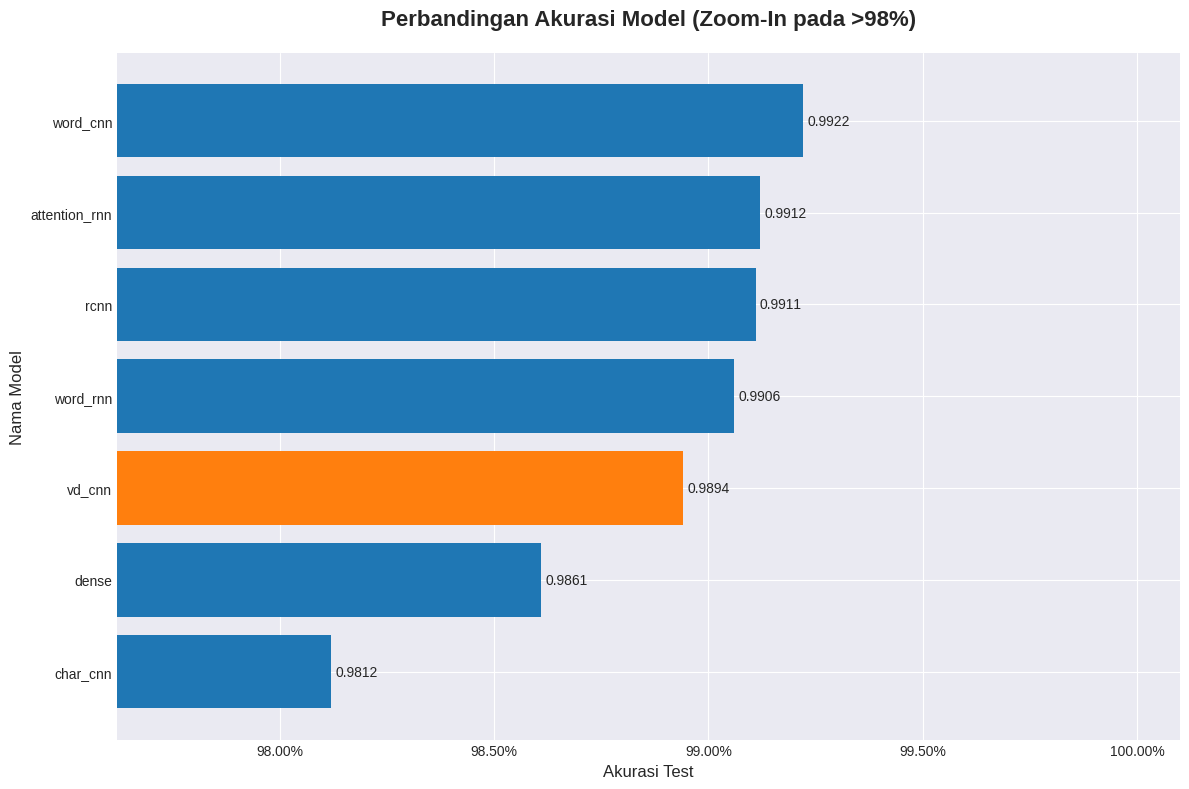



--- [3] VISUALISASI TINGKAT KESALAHAN (Error Rate) ---

Plot ini menyoroti perbedaan antar model dengan lebih jelas.


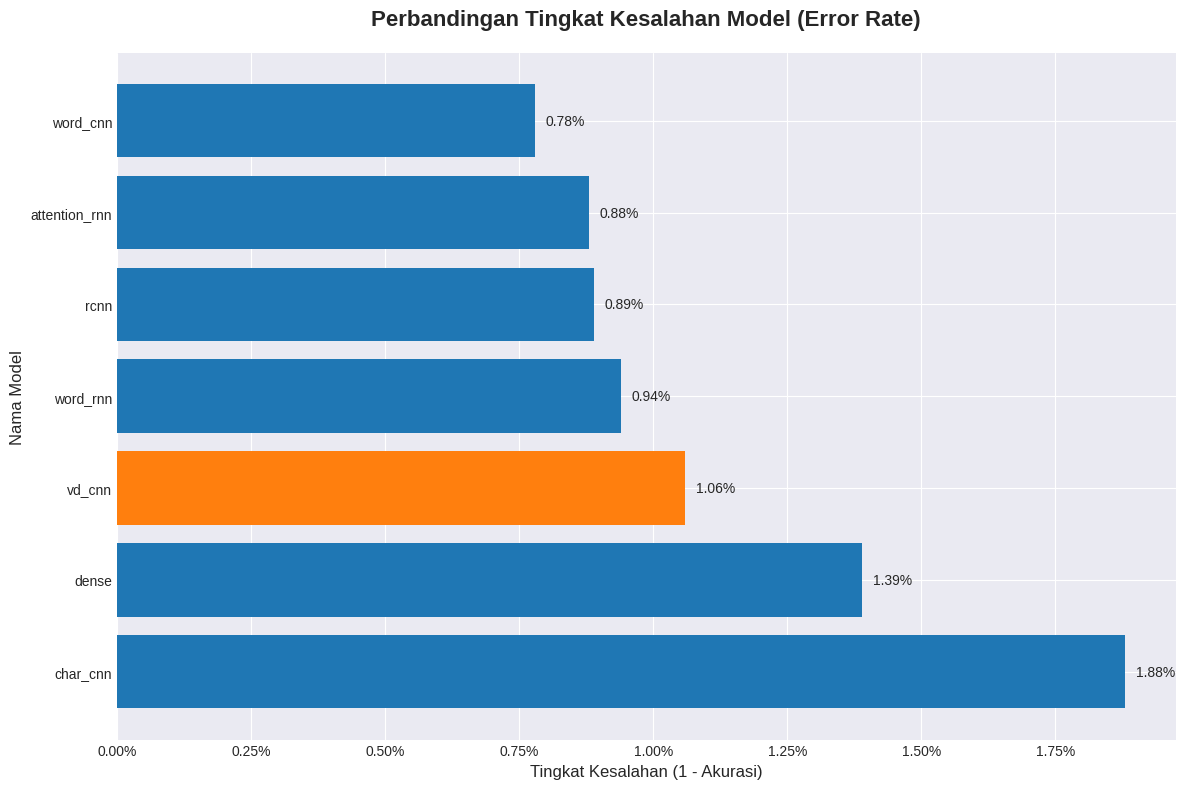

In [53]:
# ==============================================================================
# Sel 14: Analisis Kinerja, Visualisasi, dan Wawasan
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan kamus 'results' sudah terisi.
results = {
    'word_cnn': {'accuracy': 0.9922, 'loss': 0.0297},
    'attention_rnn': {'accuracy': 0.9912, 'loss': 0.0324},
    'rcnn': {'accuracy': 0.9911, 'loss': 0.0316},
    'word_rnn': {'accuracy': 0.9906, 'loss': 0.0358},
    'vd_cnn': {'accuracy': 0.9894, 'loss': 0.0390},
    'dense': {'accuracy': 0.9861, 'loss': 0.0504},
    'char_cnn': {'accuracy': 0.9812, 'loss': 0.0659}
}

print("\n" + "="*50)
print("              ANALISIS KINERJA MODEL")
print("="*50)

if not results:
    print("\n[ANALISIS] Belum ada hasil untuk dianalisis.")
else:
    # --- 1. Persiapan Data & Tabel Analisis Lanjutan ---
    results_df = pd.DataFrame(results).T.sort_values(by='accuracy', ascending=False)

    best_accuracy = results_df['accuracy'].iloc[0]
    results_df['Peringkat'] = range(1, len(results_df) + 1)
    results_df['Selisih dari Terbaik'] = results_df['accuracy'].apply(lambda x: f"{(best_accuracy - x) * -100:.2f} bps") # dalam basis points
    results_df['Tingkat Kesalahan'] = (1 - results_df['accuracy'])
    results_df['Tipe Metode'] = results_df.index.map(lambda name: 'Usulan' if 'vd_cnn' in name else 'Pembanding')

    # Buat tabel display
    results_df_display = results_df.copy()
    results_df_display['accuracy'] = results_df_display['accuracy'].apply(lambda x: f"{x:.2%}")
    results_df_display['Tingkat Kesalahan'] = results_df_display['Tingkat Kesalahan'].apply(lambda x: f"{x:.2%}")

    print("\n--- [1] TABEL ANALISIS LANJUTAN ---\n")
    print(results_df_display[['Peringkat', 'Tipe Metode', 'accuracy', 'Tingkat Kesalahan', 'Selisih dari Terbaik']])

    # --- 2. Visualisasi Perbandingan Akurasi (Zoom-In) ---
    print("\n\n--- [2] VISUALISASI AKURASI (Dengan Zoom-In) ---\n")

    min_acc = results_df['accuracy'].min()
    zoom_start = min_acc - 0.005 # Mulai sumbu sedikit di bawah akurasi terendah

    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    model_names = results_df.index
    accuracies = results_df['accuracy'].values
    colors = ['#ff7f0e' if 'vd_cnn' in name else '#1f77b4' for name in model_names]

    bars = ax.barh(model_names, accuracies, color=colors)
    ax.set_title('Perbandingan Akurasi Model (Zoom-In pada >98%)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Akurasi Test', fontsize=12)
    ax.set_ylabel('Nama Model', fontsize=12)
    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2%}'))

    # Mengatur batas sumbu-X untuk "zoom-in"
    ax.set_xlim(left=zoom_start, right=1.001)

    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.0001, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center')

    plt.tight_layout()
    plt.show()

    # --- 3. Visualisasi Tingkat Kesalahan ---
    print("\n\n--- [3] VISUALISASI TINGKAT KESALAHAN (Error Rate) ---\n")
    print("Plot ini menyoroti perbedaan antar model dengan lebih jelas.")

    fig, ax = plt.subplots(figsize=(12, 8))

    error_rates = results_df['Tingkat Kesalahan'].sort_values(ascending=False)
    model_names_sorted_by_error = error_rates.index
    colors_sorted = ['#ff7f0e' if 'vd_cnn' in name else '#1f77b4' for name in model_names_sorted_by_error]

    bars = ax.barh(model_names_sorted_by_error, error_rates, color=colors_sorted)

    ax.set_title('Perbandingan Tingkat Kesalahan Model (Error Rate)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Tingkat Kesalahan (1 - Akurasi)', fontsize=12)
    ax.set_ylabel('Nama Model', fontsize=12)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2%}'))

    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.0002, bar.get_y() + bar.get_height()/2, f'{width:.2%}', va='center')

    plt.tight_layout()
    plt.show()

